# Qiskit tests
## Creation of a circuit that implements HHL for Toeplitz symmetrical tridiagonal matrix 

This notebook is based in 2 papers:

- [1] : Harrow, A. W., Hassidim, A., Lloyd, S. (2009). Quantum algorithm for linear systems of equations. Phys. Rev. Lett. 103, 15 (2009), 1–15. <https://doi.org/10.1103/PhysRevLett.103.150502>
- [2] : Carrera Vazquez, A., Hiptmair, R., & Woerner, S. (2020). Enhancing the Quantum Linear Systems Algorithm using Richardson Extrapolation.arXiv:2009.04484 <http://arxiv.org/abs/2009.04484>`

The code is mostly based in the original code for the HHL solver in Qiskit-Algorithms

In [ ]:
import numpy as np
import matplotlib as plt
from typing import Optional, Callable
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.circuit.library import PhaseEstimation
from qiskit.circuit.library.arithmetic.piecewise_chebyshev import PiecewiseChebyshev  
from qiskit.circuit.library.arithmetic.exact_reciprocal import ExactReciprocal
from abc import ABC, abstractmethod
from numpy_matrix import NumPyMatrix

1. Build circuit
2. Build observables [2]

In [2]:
def get_delta(n_l: int, lambda_min: float, lambda_max: float) -> float:
    """Calculates the scaling factor to represent exactly lambda_min on nl binary digits.

    Args:
        n_l: The number of qubits to represent the eigenvalues.
        lambda_min: the smallest eigenvalue.
        lambda_max: the largest eigenvalue.

    Returns:
        The value of the scaling factor.
    """
    formatstr = "#0" + str(n_l + 2) + "b"
    lambda_min_tilde = np.abs(lambda_min * (2 ** n_l - 1) / lambda_max)
    # floating point precision can cause problems
    if np.abs(lambda_min_tilde - 1) < 1e-7:
        lambda_min_tilde = 1
    binstr = format(int(lambda_min_tilde), formatstr)[2::]
    lamb_min_rep = 0
    for i, char in enumerate(binstr):
        lamb_min_rep += int(char) / (2 ** (i + 1))
    return lamb_min_rep


In [13]:
#Function to build the HHL circuit
def build_circuit(matrix, vector, tolerance: float):
    """
    Builds the HHL circuit using the required args
    
    Args:
        `matrix`: The matrix that defines the linear system, i.e. A in Ax = b.
        `vector`: The right-hand side of the equation, i.e. b in Ax = b.
        `tolerance`: Tolerance of the solution bounds. This value is used to define the 3 tolerances needed for the HHL [2] equation (62).
    
    Returns:
        The HHL circuit
    
    Raises:
        ValueError: If the data is not in the right format
        ValueError: The matrix dimension is not correct
    """
    
    # Define the tolerances of the circuit
    epsilon_a = tolerance/6
    epsilon_r = tolerance/3
    epsilon_s = tolerance/3
    
    # We need an np.array to write the values to the register
    if isinstance(vector,(list,np.ndarray)):
        if isinstance(vector,list):
            vector = np.array(vector)    
        # We define the number of needed qubits and insert the vector to the register
        nb = int(np.log2(len(vector)))
        vector_circuit = QuantumCircuit(nb)
        vector_circuit.initialize(vector / np.linalg.norm(vector), list(range(nb)), None)
    else:
        raise ValueError(f"Invalid type for vector: {type(vector)}.")
    # Number of flags, dont know if needed
    nf = 1
    
    # Input the matrix A for the QPE
    if isinstance(matrix, (list, np.ndarray)):
        if isinstance(matrix, list):
            matrix = np.array(matrix)

        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError("Input matrix must be square!")
        
        if np.log2(matrix.shape[0]) % 1 != 0:
            raise ValueError("Input matrix dimension must be 2^n!")
        
        if not np.allclose(matrix, matrix.conj().T):
            raise ValueError("Input matrix must be hermitian!")
        
        if matrix.shape[0] != 2 ** vector_circuit.num_qubits:
            raise ValueError(
                "Input vector dimension does not match input "
                "matrix dimension! Vector dimension: "
                + str(vector_circuit.num_qubits)
                + ". Matrix dimension: "
                + str(matrix.shape[0])
            )
        # We default to a TridiagonalToeplitz matrix, but in a general case we would use a more general library
        # Also, we want the evolution_time to be 2pi/\landa_{max}, but we update it after, when we have the eigenvalues of the matrix
        matrix_circuit = NumPyMatrix(matrix,evolution_time=2 * np.pi, tolerance=epsilon_a)
        
        # General case
        # matrix_circuit = NumPyMatrix(matrix, evolution_time=2 * np.pi)
        
    else:
        raise ValueError(f"Invalid type for matrix: {type(matrix)}.")
    
    # Define condition and eigenvalue bounds    
    if (hasattr(matrix_circuit, "condition_bounds")):
        kappa = matrix_circuit.condition_bounds()[1]
    else:
        kappa = 1
        
    # Using kappa, the condition bound,  we define nl, the number of qubits needed to represent the eigenvalues
    nl = max(nb+1,int(np.log2(kappa))+1)
    
    # Define eigenvalues
    if hasattr(matrix_circuit, "eigs_bounds"):
        lambda_min, lambda_max = matrix_circuit.eigs_bounds()
        # Constant so that the minimum eigenvalue is represented exactly, since it contributes
        # the most to the solution of the system
        delta = get_delta(nl, lambda_min, lambda_max)
        # Update evolution time
        matrix_circuit.evolution_time = 2 * np.pi * delta / lambda_min
        # Update the scaling of the solution
        scaling = lambda_min
    else:
        delta = 1 / (2 ** nl)
        print("The solution will be calculated up to a scaling factor.")
    
        
    # Define the reciprocal circuit
    
    # # Using an exact reciprocal circuit
    # reciprocal_circuit = ExactReciprocal(nl, delta)
    # # Update number of ancilla qubits
    # na = matrix_circuit.num_ancillas
    
    # Using Chebyshev interpolation to approximate arcsin(C/x) to a degree of degree
    
    # Calculate breakpoints for the reciprocal approximation
    num_values = 2 ** nl
    constant = delta
    # a as [2] indicates
    
    # No tengo para nada claro esto, no encuentro que hay que hacer con la a para pasarla a entero
    a = int(2**(2*nl/3))  # pylint: disable=invalid-name

    # Calculate the degree of the polynomial and the number of intervals
    r = 2 * constant / a + np.sqrt(np.abs(1 - (2 * constant / a) ** 2))
    degree = min(
        nb,
        int(
            np.log(
                1
                + (
                    16.23
                    * np.sqrt(np.log(r) ** 2 + (np.pi / 2) ** 2)
                    * kappa
                    * (2 * kappa - epsilon_r)
                )
                / epsilon_r
            )
        ),
    )
    # As [2]
    num_intervals = int(np.ceil(np.log((num_values - 1) / a) / np.log(5)))

    # Calculate breakpoints and polynomials
    breakpoints = []
    for i in range(0, num_intervals):
        # Add the breakpoint to the list
        breakpoints.append(a * (5 ** i))

        # Define the right breakpoint of the interval
        if i == num_intervals - 1:
            breakpoints.append(num_values - 1)
    # Once we have the intervals, and everything is defined, we can make an approximation by a polynomial function of degree
    reciprocal_circuit = PiecewiseChebyshev(
        lambda x: np.arcsin(constant / x), degree, breakpoints, nl, name="c_Rotation"
    )
    # Number of ancilla qubits
    na = max(matrix_circuit.num_ancillas, reciprocal_circuit.num_ancillas)
    
    # Construction of the circuit
    
    # Define registers
    qb = QuantumRegister(nb,name="b")
    ql = QuantumRegister(nl,name="0")
    qf = QuantumRegister(nf,name="flag")
    if na > 0:
        qa = AncillaRegister(na,name="anc")
        qc = QuantumCircuit(qb,ql,qa,qf)
    else:
        qc = QuantumCircuit(qb,ql,qf)
    
    # State preparation
    # Vector initialization
    qc.append(vector_circuit,qb[:])
    # QPE
    phase_estimation = PhaseEstimation(nl,matrix_circuit)
    if na > 0:
        qc.append(phase_estimation, ql[:] + qb[:] + qa[: matrix_circuit.num_ancillas])
    else:
        qc.append(phase_estimation, ql[:] + qb[:])
    #Conditioned rotation
    qc.append(reciprocal_circuit.to_instruction(),ql[:] + [qf[0]] + qa[: reciprocal_circuit.num_ancillas])
    #QPE^{\dagger}
    if na > 0:
        qc.append(phase_estimation.inverse(), ql[:] + qb[:] + qa[: matrix_circuit.num_ancillas])
    else:
        qc.append(phase_estimation.inverse(), ql[:] + qb[:])
        
    return qc

In [9]:
# Calc observables
def calc_observables(qc: QuantumCircuit, observable: Optional[int] = 3):
    """Calculates the value of the observable(s) given.

        Args:
            `qc`: The quantum circuit preparing the solution x to the system.
            # TODO
            # Not yet implemented
            `observable`: Information to be extracted from the solution. 1 - ||x'||, 2 - F_b(x), 3 - Average solution
            `post_processing`: Function to compute the value of the observable.

        Returns:
            The value of the observable(s) and the circuit results before post-processing as a tuple.
        """
    nb = qc.qregs[0].size
    nl = qc.qregs[1].size
    na = qc.num_ancillas
    
    
    
    return solution

In [10]:
# Solve circuit
def solve(qc: QuantumCircuit):
    
    return solution

### Celda de pruebas

In [11]:
int(2.99)

2

num_values= 4
a= 2
num_intervals= 1
breakpoints= [2, 3]


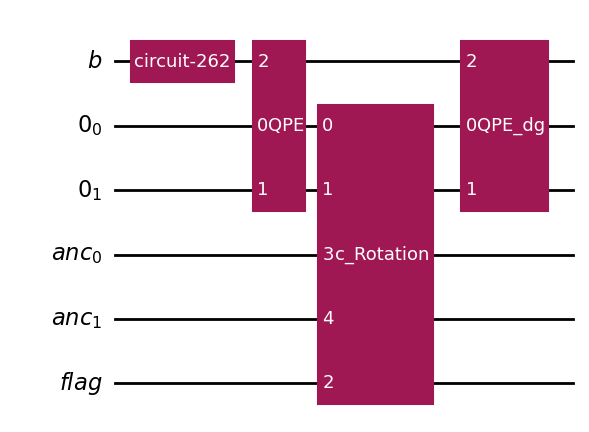

In [12]:
vector = np.array([1,0])
matrix = np.array([[1,-1/3],[-1/3,1]])

hhl = build_circuit(matrix,vector,10e-6)

hhl.draw('mpl')